In [1]:
%pip install -q -U anthropic
%pip install -q -U lightning
%pip install -q -U bitsandbytes
%pip install -q -U transformers
%pip install -q -U peft
%pip install -q -U accelerate
%pip install -q -U wandb
%pip install -q -U datasets
%pip install -q -U prodigyopt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradient 2.0.6 requires attrs<=19, but you have attrs 23.1.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import base64
from anthropic import Anthropic
from IPython.display import Image, display
import os
import json
import random
import torch
from transformers import BitsAndBytesConfig
from transformers import AutoProcessor, VisionEncoderDecoderModel
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
from transformers import DonutProcessor
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
import os, torch, torch.nn as nn, torch.utils.data as data, torchvision as tv
import lightning as L
from transformers import DonutProcessor, VisionEncoderDecoderModel
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import wandb
import logging
import os
from pathlib import Path
from IPython.display import Image
from tqdm.auto import tqdm
from IPython.display import Image
import pickle
import torchvision.transforms as T
from datasets import Dataset
from datasets import IterableDataset
from tqdm.auto import tqdm
import unicodedata
import os
import gc
import torch
from torch.utils.data import Dataset
import torchvision as tv
import torchvision.transforms as T
from transformers import DonutProcessor
import random
from torch.utils.data import Subset

2024-09-24 09:41:50.266687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 09:41:50.266717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 09:41:50.267936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 09:41:50.483847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 09:41:52.471598: W tensorflow/compiler/tf2

In [3]:
DATASET_PATH = "./documents"
PDF_PATH = os.path.join(DATASET_PATH, "german_pdf_files")
IMAGE_PATH = os.path.join(DATASET_PATH, "german_img_files")


class DocMeta:
    def __init__(self, dataset_path=DATASET_PATH, image_path=IMAGE_PATH):
        self.dataset_path = dataset_path
        self.image_path = image_path
        self.extraction = self.load_extraction(self.dataset_path)
        self.mapping = self.load_mapping(self.image_path)

    def get_random_urls(self, num=100):
        return random.sample(list(self.extraction.keys()), num)

    def load_extraction(self, path):
        with open(os.path.join(path, "extraction.json"), "r") as f:
            return json.load(f)

    def load_mapping(self, path):
        with open(os.path.join(path, "mapping.json"), "r") as f:
            return json.load(f)

    def get_image_path(self, url):
        return os.path.join(self.image_path, self.mapping[url])

    def get_image(self, url):
        img_path = self.get_image_path(url)
        return Image(filename=img_path)


doc_meta = DocMeta()

In [4]:
class DocMetaDataset(Dataset):
    def __init__(self, doc_meta, output_dir, ocr=False):
        self.doc_meta = doc_meta
        self.task_start_token = "<s>"
        self.eos_token = "</s>"
        self.processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
        self.processor.tokenizer.add_special_tokens(
            {"additional_special_tokens": [self.task_start_token, self.eos_token]}
        )
        self.processor.feature_extractor.size = [2160, 3840]
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        self.data = self._prepare_data()
        self.ocr = ocr

    def _prepare_data(self):
        data = []
        for url in tqdm(
            list(self.doc_meta.extraction.keys()), desc="Preparing dataset"
        ):
            main_author = self.doc_meta.extraction[url]["metadata"]["main_author"]

            transcript = self.doc_meta.extraction[url]["transcript"]

            transcript = self.task_start_token + transcript + self.eos_token

            if not main_author is None:

                if "name" in main_author:

                    author = main_author["name"]

                elif "first_name" in main_author and "last_name" in main_author:

                    author = ""
                    if main_author["first_name"] is not None:
                        author += main_author["first_name"]
                    if main_author["last_name"] is not None:
                        author += " " + main_author["last_name"]

                elif "department" in main_author:

                    author = main_author["department"]

                else:
                    continue
            else:
                continue

            author = self.task_start_token + author + self.eos_token
            image_path = self.doc_meta.get_image_path(url)

            image_data = tv.io.read_image(unicodedata.normalize("NFC", image_path))
            res = tv.transforms.functional.get_image_size(image_data)

            if res[0] > 2160 or res[1] > 3840:
                continue

            if author.replace(" ", "") == "<s></s>":
                continue

            if len(author) > 80:
                continue

            data.append((image_path, author, url, transcript))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, author, url, transcript = self.data[idx]

        image_data = tv.io.read_image(unicodedata.normalize("NFC", image_path))
        image_data = image_data.permute(1, 2, 0)

        pixel_values = self.processor(image_data, return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze().half()

        if not self.ocr:
            input_ids_author = (
                self.processor.tokenizer(
                    author,
                    add_special_tokens=False,
                    padding="max_length",
                    truncation=True,
                    max_length=80,
                    return_tensors="pt",
                )["input_ids"]
                .squeeze(0)
                .long()
            )

            author_target = input_ids_author.clone()
            author_target[author_target == self.processor.tokenizer.pad_token_id] = -100
            return {"pixel": pixel_values, "target": author_target, "url": url}

        if self.ocr:
            input_ids_transcript = (
                self.processor.tokenizer(
                    transcript,
                    add_special_tokens=False,
                    padding="max_length",
                    truncation=True,
                    max_length=300,
                    return_tensors="pt",
                )["input_ids"]
                .squeeze(0)
                .long()
            )
            transcript_target = input_ids_transcript.clone()
            transcript_target[
                transcript_target == self.processor.tokenizer.pad_token_id
            ] = -100
            return {"pixel": pixel_values, "target": transcript_target, "url": url}

    def get_split(self, train_ratio=0.8, seed=None):
        """
        Returns train and test splits as two Subset objects.
        """
        total_size = len(self.data)
        train_size = int(train_ratio * total_size)

        indices = list(range(total_size))
        if seed is not None:
            random.Random(seed).shuffle(indices)
        else:
            random.shuffle(indices)

        train_indices = indices[:train_size]
        test_indices = indices[train_size:]

        train_dataset = Subset(
            self,
            train_indices,
        )
        test_dataset = Subset(
            self,
            test_indices,
        )

        return train_dataset, test_dataset

In [5]:
dataset = DocMetaDataset(doc_meta, "./")

preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/donut/processing_donut.py:193: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Preparing dataset:   0%|          | 0/4702 [00:00<?, ?it/s]

In [6]:
train, test = dataset.get_split(0.9)

In [7]:
dataset.ocr = True

In [8]:
batch_size = 1
num_workers = 10

train_dataloader = DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
)

test_dataloader = DataLoader(
    test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model_nf4 = VisionEncoderDecoderModel.from_pretrained(
    "naver-clova-ix/donut-base", quantization_config=nf4_config
)

model_nf4.decoder.resize_token_embeddings(len(dataset.processor.tokenizer))
model_nf4.config.pad_token_id = dataset.processor.tokenizer.pad_token_id
model_nf4.config.decoder_start_token_id = (
    dataset.processor.tokenizer.convert_tokens_to_ids(["<s>"])[0]
)

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [10]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=128, lora_dropout=0.05, r=256, bias="none", target_modules="all-linear"
)

model = get_peft_model(model_nf4, peft_config)

model.print_trainable_parameters()

trainable params: 89,634,048 || all params: 291,486,072 || trainable%: 30.7507


In [11]:
import torch
from torch.optim.lr_scheduler import LinearLR
import lightning as L
from prodigyopt import Prodigy


class Donut(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        outputs = self.model(
            pixel_values=batch["pixel"].to("cuda"), labels=batch["target"]
        )
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.model(
            pixel_values=batch["pixel"].to("cuda"), labels=batch["target"]
        )
        loss = outputs.loss
        self.log("val_loss", loss)

    def predict_step(self, batch):
        self.model.eval()
        return self.model.generate(batch["pixel"].to("cuda"))

    def configure_optimizers(self):
        optimizer = Prodigy(
            self.model.parameters(),
            lr=1.0,
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10 * len(train_dataloader)
        )

        return [optimizer], [scheduler]

In [12]:
model_module = Donut(model)

In [13]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
wandb.init(project="Donut")

wandb: Currently logged in as: jonasg. Use `wandb login --relogin` to force relogin


In [15]:
wandb_logger = WandbLogger(project="Donut", log_model="all")
checkpoint_callback = ModelCheckpoint()

In [16]:
trainer = L.Trainer(
    accelerator="gpu",
    devices=1,
    num_sanity_val_steps=2,
    max_epochs=10,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    log_every_n_steps=100,
    val_check_interval=500,
    precision="16-mixed",
    accumulate_grad_batches=10,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [17]:
pl_logger = logging.getLogger("lightning")
pl_logger.propagate = False

In [18]:
torch.set_float32_matmul_precision("medium")

In [34]:
trainer.fit(
    model_module,
    train_dataloaders=train_dataloader,
    val_dataloaders=test_dataloader,
)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 220 M  | train
--------------------------------------------
89.6 M    Trainable params
131 M     Non-trainable params
220 M     Total params
883.877   Total estimated model params size (MB)
1642      Modules in train mode
484       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
dataset.ocr = False

In [ ]:
trainer.fit(
    model_module,
    train_dataloaders=train_dataloader,
    val_dataloaders=test_dataloader,
)

In [21]:
checkpoint_reference = "jonasg/Donut/model-9ob0xh3b:v17"
wandb_logger.download_artifact(checkpoint_reference, artifact_type="model")

wandb: Downloading large artifact model-9ob0xh3b:v17, 1898.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:18.5


'/notebooks/artifacts/model-9ob0xh3b:v17'

In [ ]:
model_module = Donut.load_from_checkpoint(
    "artifacts/model-75qnxg47:v4/model.ckpt", model=model, strict=False
)

In [22]:
loaded_model_module = Donut.load_from_checkpoint(
    "artifacts/model-9ob0xh3b:v17/model.ckpt", model=model, strict=False
)

In [23]:
preds = trainer.predict(loaded_model_module, dataloaders=test_dataloader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Information für der Anwender


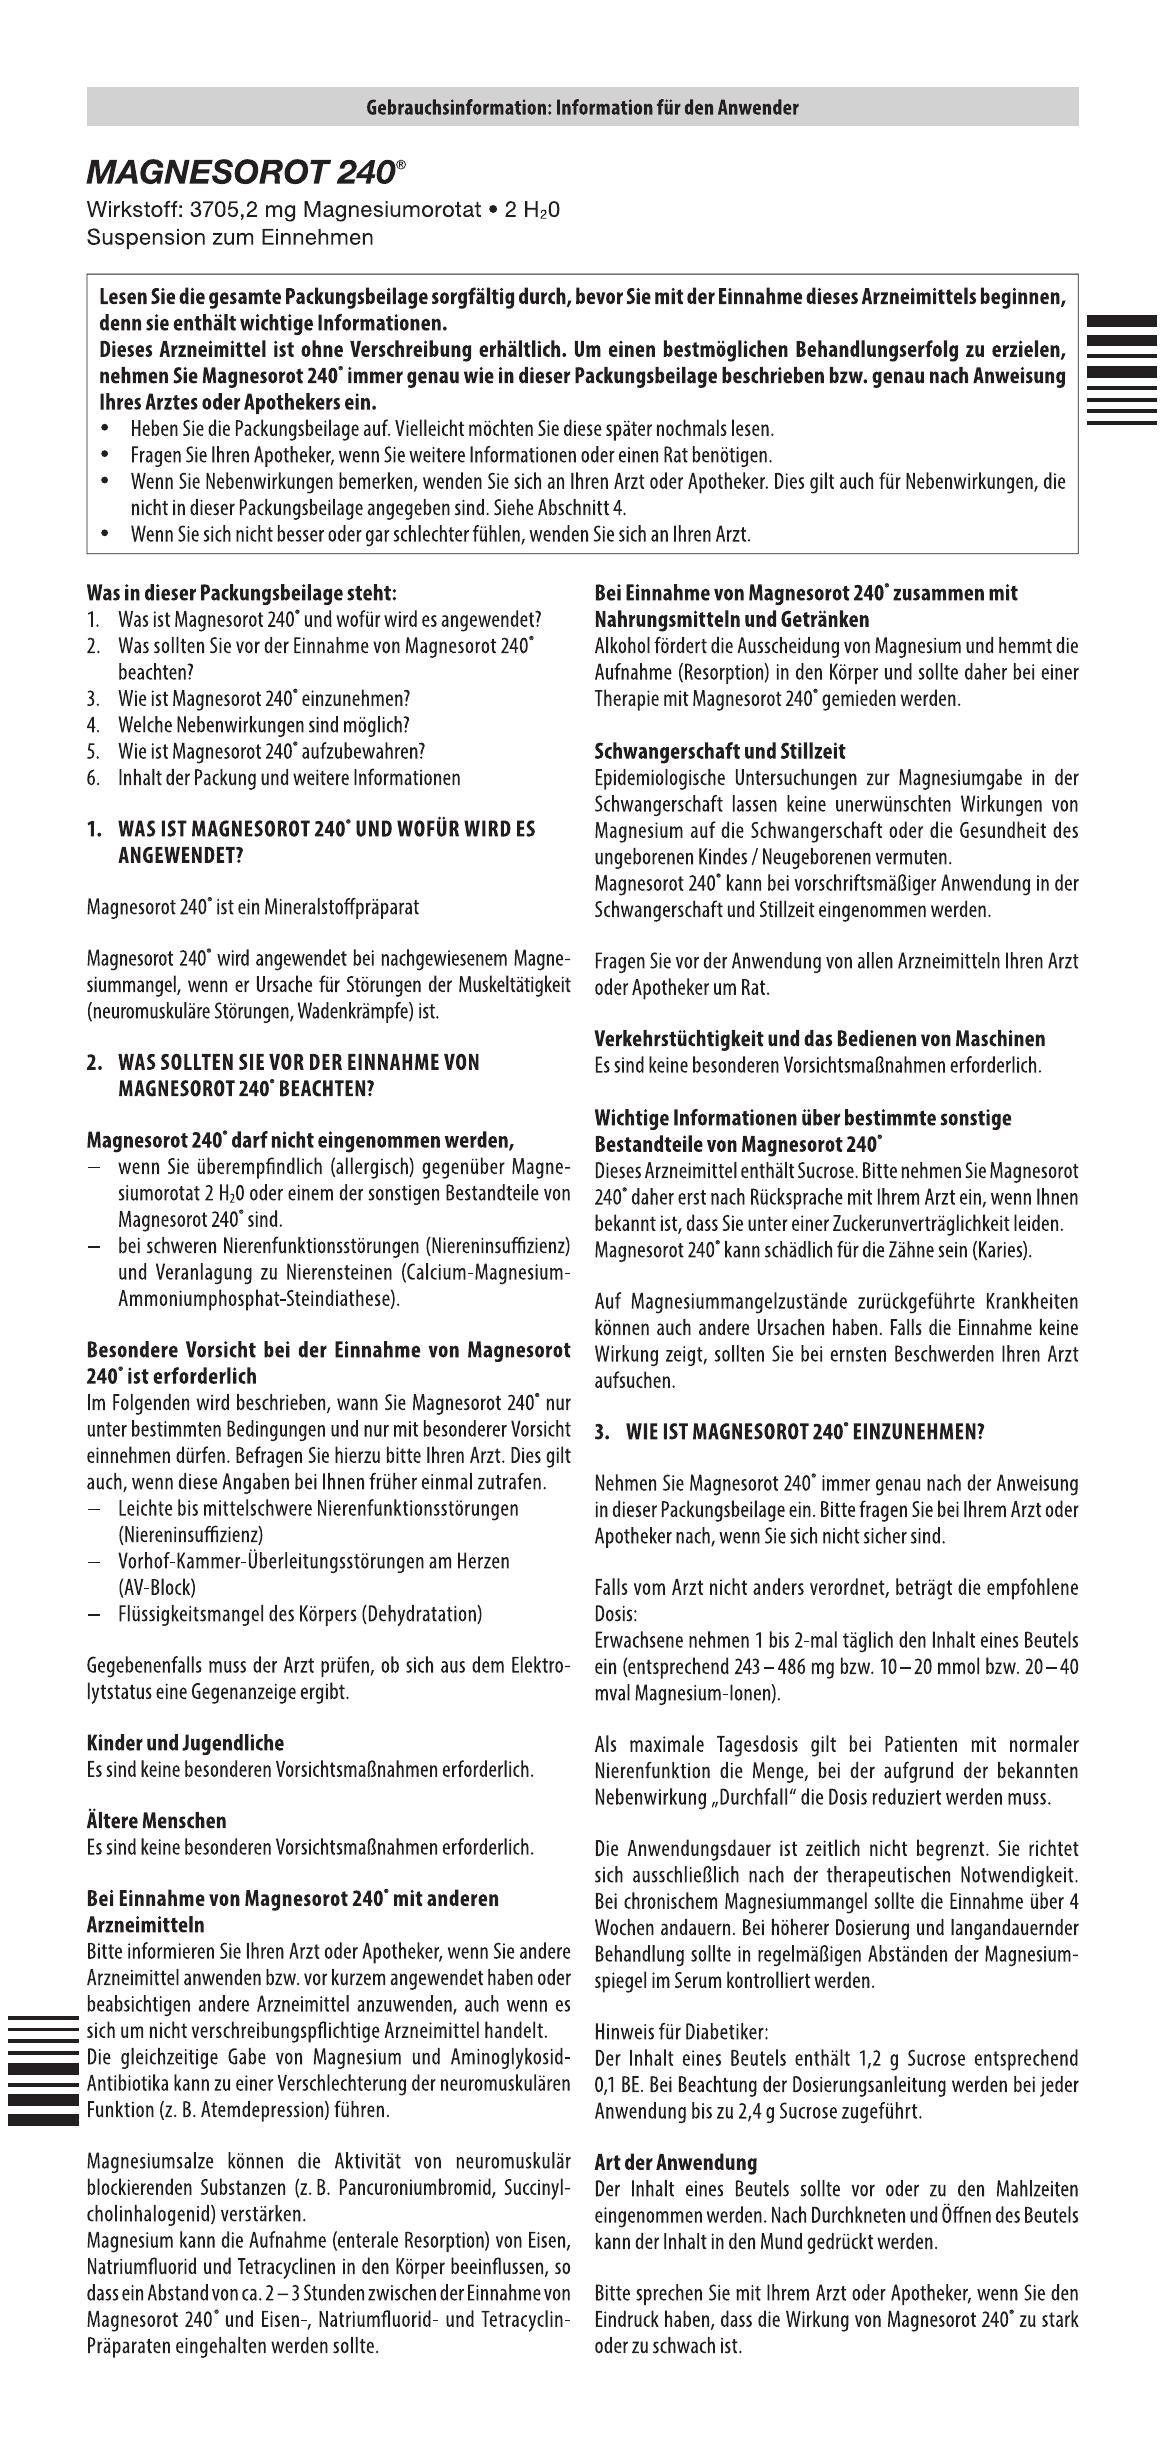

In [102]:
idx = 88
idx = 100
idx = 5
idx = 10
idx = 90
idx = 300
idx = 58
idx = 24
idx = 46
# idx = 61
# idx = 52
# idx = 19
# idx = 93
# idx = 32
# idx = 67
# idx = 149
# idx = 325
# idx = 333
# idx = 341
# idx = 211

# Fehler

idx = 71
idx = 321
idx = 56
idx = 98
idx = 38
idx = 82
idx = 322
# idx = 243


predicted_label = dataset.processor.batch_decode(preds[idx], skip_special_tokens=True)[
    0
]
print(predicted_label)
res = test_dataloader.dataset[idx]
url = res["url"]
doc_meta.get_image(url)

# 2nd Dataset


In [ ]:
%pip install -q -U pdf2image

In [ ]:
!sudo apt install poppler-utils

In [ ]:
import json
from urllib.parse import urlparse, urlunparse
from pdf2image import convert_from_path, convert_from_bytes
from tqdm.auto import tqdm
import os
import tempfile

In [ ]:
PDF_PATH = "./drive/MyDrive/Colab Data/german_pdf_files"
PDF_TO_IMG_PATH = "./drive/MyDrive/Colab Data/german_img_files"

mappings = json.load(open(os.path.join(PDF_PATH, "mapping.json"), "r"))

mappings_img = {}  # contains all mappings which converted without error

for url, file_name in tqdm(mappings.items()):
    pdf_path = os.path.join(PDF_PATH, file_name)
    try:
        with tempfile.TemporaryDirectory() as path:
            image_data = convert_from_path(
                pdf_path, output_folder=path, fmt="jpeg", first_page=1, last_page=1
            )[0]
            image_data.save(
                os.path.join(PDF_TO_IMG_PATH, file_name.replace(".pdf", ".jpg"))
            )
            mappings_img[url] = file_name.replace(".pdf", ".jpg")
            with open(os.path.join(PDF_TO_IMG_PATH, "mapping.json"), "w") as f:
                json.dump(mappings_img, f)
    except:
        print("Error")
        continue

In [ ]:
PDF_PATH = "./drive/MyDrive/Colab Data/german_pdf_files"

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

import tempfile


class PdfDataset(Dataset):

    def __init__(self):
        cnt = 0
        self.documents = []
        self.mappings = json.load(open(os.path.join(PDF_PATH, "mapping.json"), "r"))

        for url, file_name in tqdm(self.mappings.items()):
            cnt += 1
            pdf_path = os.path.join(PDF_PATH, file_name)
            try:

                with tempfile.TemporaryDirectory() as path:
                    image_data = convert_from_path(
                        pdf_path,
                        output_folder=path,
                        fmt="jpeg",
                        first_page=1,
                        last_page=1,
                    )[0]
            except:
                print("Error")
                continue

            pixel_values = processor(image_data, return_tensors="pt").pixel_values
            pixel_values = pixel_values.squeeze().half()

            label = (
                urlparse(url)
                .hostname.replace("www.", "")
                .replace(".de", " ")
                .replace(".", " ")
                .replace("-", " ")
                .replace("_", " ")
            )
            print(label)
            input_ids = processor.tokenizer(
                label,
                add_special_tokens=False,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )["input_ids"].squeeze(0)

            self.documents.append((pixel_values, input_ids, pdf_path))
            if cnt == 200:
                break

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, idx):
        return self.documents[idx]


documents_dataset = PdfDataset()

In [ ]:
train, test = train_test_split(documents_dataset, test_size=0.33, random_state=42)

train_dataloader = DataLoader(train, batch_size=1, shuffle=False, num_workers=4)
val_dataloader = DataLoader(test, batch_size=1, shuffle=False, num_workers=4)

In [ ]:
trainer.fit(
    model_module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

In [ ]:
# TODO: possibly get better label by extracting info form website / impressum?